In [2]:
#loading the library
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Questions chosen

**Broad question chosen**: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

**Specific question chosen**: Which of the predictors—age, gender, subscription status, or experience level- contributes the most to predicting high gameplay hours?

In [3]:
#read data from web
players_data <- read_csv("https://raw.githubusercontent.com/thaviship/individual-planning-dsci-100/refs/heads/main/players.csv", 
                         col_names=TRUE)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Data Description

The dataset contains 196 observations and 7 variables describing player demographics and gameplay activity. 

|Variable Name | Type | Description |
|--------------| -----| ------------|
|experience | categorical (factor) | Player's experience level|
|subscribe | categorical (logical) | Whether or not the player has a game subscription (subscribed= TRUE)|
|hashedEmail | String | A hashed version of the player's email address. Not useful for modelling|
|played_hours | numeric (continuous) | Total hours the player spent playing the game. This is the **response variable**|
|name| String/Categorical | Player's chosen name on game server. Not useful for modelling|
|gender| Categorical (factor) | Self reported gender category of the players |
|age| Numeric (integer) | Player's age in years|


In [22]:
#stat calculations for played_hours and age

mean_age <- players_data |>
  summarise(Age_mean = mean(Age, na.rm = TRUE)) 
mean_age

mean_played_hours <- players_data |> summarise(played_hours_mean = mean(played_hours, na.rm = TRUE))
mean_played_hours

max_value_played_hours<- players_data |> summarise(max_played_hours=max(played_hours, na.rm=TRUE))
max_value_played_hours

min_value_played_hours<- players_data |> summarise(min_played_hours=min(played_hours, na.rm=TRUE))
min_value_played_hours

max_age<- players_data |> summarise(max_age=max(Age, na.rm=TRUE))
max_age

min_age<- players_data |> summarise(min_age=min(Age, na.rm=TRUE))
min_age

Age_mean
<dbl>
21.13918


played_hours_mean
<dbl>
5.845918


max_played_hours
<dbl>
223.1


min_played_hours
<dbl>
0


max_age
<dbl>
58


min_age
<dbl>
9


#### Statistics Summary for Age and played_hours

|Variable Name | Age | played_hours |
|--------------| -----| ------------|
|mean value | 21.14  | 5.85|
|max value | 58 | 223.10 |
|min value | 9 | 0 |


#### Potential Issues in Dataset

Several issues occur in the data, including duplicate entries,some gender categories have fewer than five observations, making them too sparse to reliably estimate category-specific effects which could lead to unstable or inconsistent model coefficients if included, missing values in the age column, and unnecessary identifier variables such as hashedEmail and name.

Since the goal of this project is specifically to identify which groups contribute more gameplay data—not simply who logs in—the analysis focuses on players who have played more than zero hours. Therefore, the dataset needs to be tidied in order to answer the predictive question accurately.


In [23]:
#tidy data
players_tidy <- players_data |> 

# Select out the hashedEmail and name column vectors as they are identifiers and contain no predictive information.
                select(-hashedEmail, -name) |> 

#Convert subscribe, experience, and gender character variables to factor variables so that R can treat them as categorical variables.
  mutate(subscribe_fct=as_factor(subscribe)) |> 
  mutate(experience_fct=as_factor(experience)) |>
  mutate(gender_fct=as_factor(gender)) |>

#Filter out the played_hours variable and select only those who have >0 gameplay hours. Zero-hour players are non-contributors and do not contribute to the goal of identifying high-engagement users.
                filter(played_hours>0) |> 

#Remove rows with missing Age, as leaving NA values leads to loss of rows silently and inconsistencies in model prediction.
         filter(!is.na(Age)) |>   

#To deal with extreme outliers in played_hours, transform highly skewed values into log as it compresses the large values, which makes the distribution closer to normal and stabilizes variance. 
         mutate(played_hours_log = log(played_hours + 1))
               

#remove non fct columns to prevent multicollinearlity when performing multivariable linear regression

players_clean<- players_tidy |> select(experience_fct, subscribe_fct, gender_fct, Age, played_hours_log)

head(players_clean)

experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,Male,9,3.44361810
Veteran,TRUE,Male,17,1.56861592
Amateur,TRUE,Female,21,0.53062825
Regular,TRUE,Male,21,0.09531018
Amateur,TRUE,Male,47,0.09531018
Veteran,TRUE,Female,23,0.95551145


## Visualisation 

### 1. Distribution of Played Hours by Experience Level and Subscribers

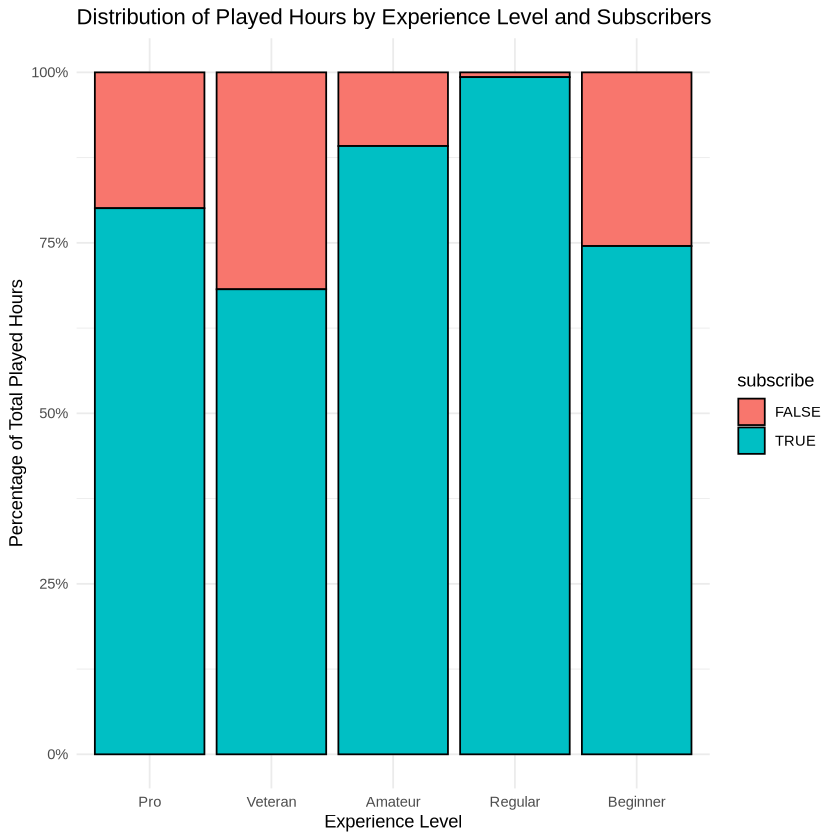

In [10]:
plot_data <- players_clean |>
  group_by(experience_fct, subscribe_fct) |>
  summarise(total_hours = sum(played_hours_log), .groups = "drop") |> group_by(experience_fct) |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct <- ggplot(plot_data,
                                         aes(x = experience_fct,
                                             y = percentage,fill=subscribe_fct)) +
  geom_bar(stat = "identity", position = "fill", colour="black") +
  scale_y_continuous(labels = percent_format()) +
  labs(
    x = "Experience Level",
    y = "Percentage of Total Played Hours",
    title = "Distribution of Played Hours by Experience Level and Subscribers",
fill="subscribe") +
  theme_minimal()

experience_gender_percent_plot_fct

#### Insight: 

The percentage of total hours has been used as it allows to compare how gameplay activity is distributed between subscribers and non-subscribers within each experience level. It normalises each group to 100% which prevent extreme values from distorting the comparison. Hence, the visualisation shows that subscription status is strongly related with higher gameplay hours. Across all experience levels, subscribers contributes the vast majority of total played hours which indicates that being a subscriber is one of the clearest predictors of heavy engagement. However experience level variable still plays a major role as the visualisation depicts that more advanced groups like Pro and Regular tend to show higher total hours but the dominant trend is that subscribers consistently play more regardless of their experience category. 

### 2. Distribution of Played hours by Gender

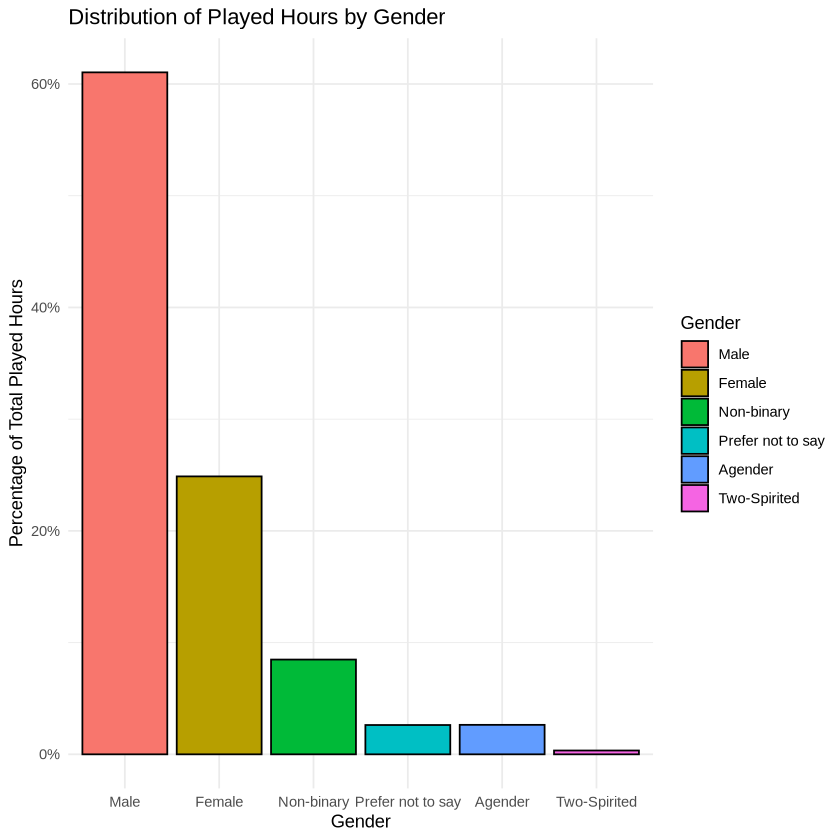

In [11]:
plot_data <- players_clean |>
  group_by(gender_fct) |> 
  summarise(total_hours = sum(played_hours_log), .groups = "drop") |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct <- ggplot(plot_data,
                                             aes(x = gender_fct,
                                                 y = percentage, fill=gender_fct)) +
  geom_bar(stat = "identity", colour = "black") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    x = "Gender",
    y = "Percentage of Total Played Hours",
    title = "Distribution of Played Hours by Gender",
  fill="Gender") +
  theme_minimal()

experience_gender_percent_plot_fct


#### Insight:

The y value of this plot has been converted to a percentage, as it represents the relative contributions of each gender, given that it prevents a single heavy gamer from making a gender group look bigger. Hence, it clearly depicts that male players account for nearly 60% of the total hours logged, and female players contribute to roughly 25% followed by the other 4 categories which have minor contributions to gameplay hours. This suggests that gender is associated with overall gameplay hours, with the male category driving the majority of the hours. 

### 3. Distribution of Player Ages by Subscription Status

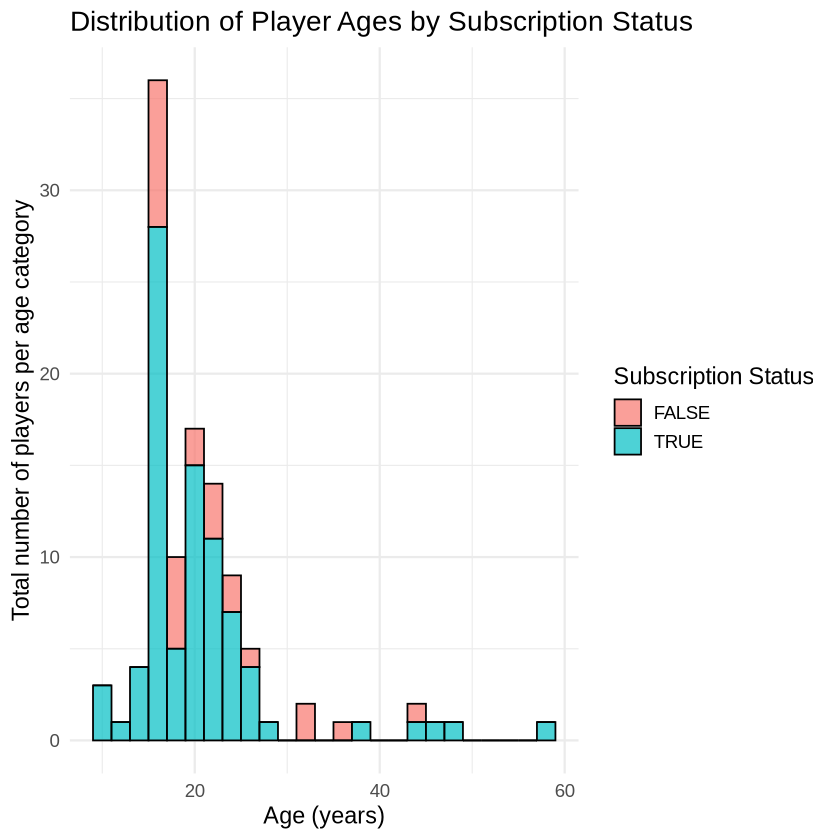

In [12]:
players_age_hours_hist <- players_clean |> 
   ggplot(aes(x = Age, fill = subscribe_fct)) +
  geom_histogram(binwidth = 2,color="black", alpha=0.7) +
  labs(
    title = "Distribution of Player Ages by Subscription Status",
    x = "Age (years)",
    y = "Total number of players per age category",
    fill = "Subscription Status"
  ) +
  theme_minimal(base_size = 14) 
  
players_age_hours_hist

#### Insight

A histogram is used as age is a continuous variable and thus it helps in comparing distribution of player ages across subscription category. It clearly shows that subscription is strongly tied to age, where young adults in the 16-24 age category are not only major contributors to gameplay hours but are also the group most likely to be subscribers. Outside of that 16-24 age category, subscriptions drop off more sharply which means that older or very young players are less likely to subscribe and, as such, contribute to gameplay hours. 

### 4. Total Hours Played by Experience Level

experience_fct,total_hours
<fct>,<dbl>
Pro,7.590369
Veteran,13.301916
Amateur,36.530174
Regular,27.261411
Beginner,14.002397


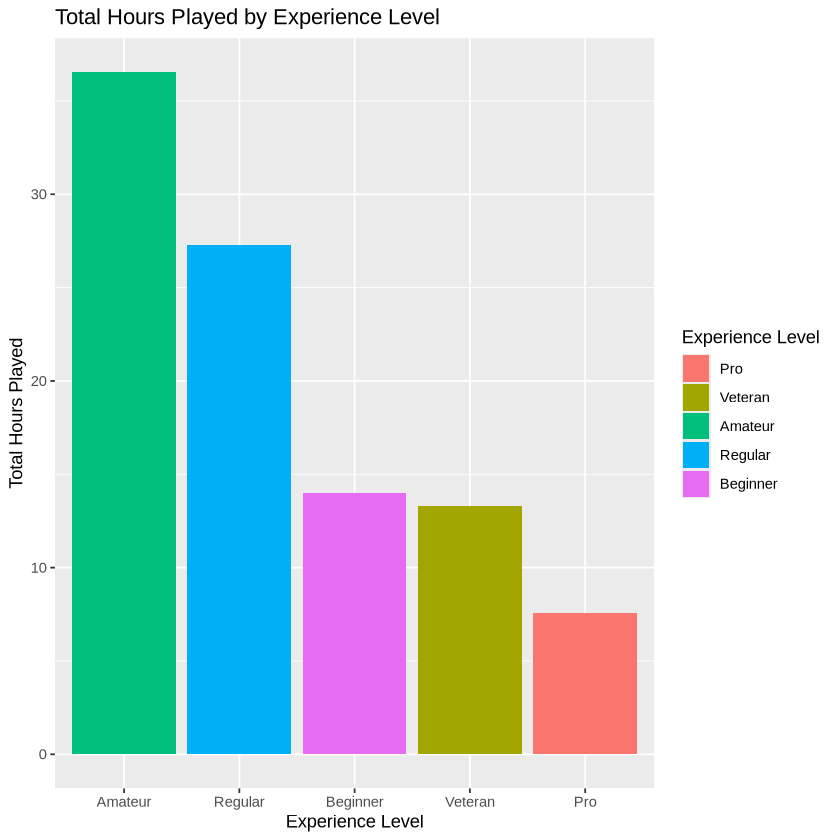

In [13]:
bar_plot_tidy_players <- players_clean |>
  group_by(experience_fct) |>
  summarise(total_hours = sum(played_hours_log), .groups = "drop")
bar_plot_tidy_players

bar_plot_experience_vs_totalhrs <- bar_plot_tidy_players |> 
  ggplot(aes(x = fct_reorder(experience_fct, total_hours, .desc=TRUE),
             y = total_hours,
             fill = experience_fct)) +
  geom_bar(stat = "identity") +
  labs(x = "Experience Level", 
       y = "Total Hours Played", 
       fill = "Experience Level",title = "Total Hours Played by Experience Level")

bar_plot_experience_vs_totalhrs

#### Insight

The values for total played hours haven't been converted to percentages here, as the raw values show how much each group actually contributes and highlights the real difference between the self-reported experience level of the players and the total hours played. The biggest share of gameplay hours comes from mid-level players that fall into the Amateur and Regular categories. True novices like Beginners and highly skilled players like Pros contribute less to gameplay hours. Hence, these observations suggest that the core contributors to gameplay hours are mid-skilled players (Amateurs and Regulars)

## Methods and Plan

To address the predictive question, a multivariable linear regression model that predicts gameplay hours using subscribe, experience level, gender, and age variables among players who have contributed the most will be used. 

This method is appropriate because the response variable (played_hours and its log transformation) is continuous and linear regression is designed to model the relationship between the numeric outcome and multiple predictor variables (experience level, gender, age, and subscription variables). The  predictor variables can be converted into dummy variables that linear regression can handle. The model thus allows us to estimate the contribution of each predictor to gameplay hours while holding other variables constant. 

Some assumptions required will be that each predictor should have a linear relationship with the outcome (possibly after transformation), and each row represents a different player, which is reasonable. Predictors should also not be perfectly or highly correlated, which is why only the mutated factor variables for gender, subscribe, and experience have to be selected. 

Some potential limitations of this model involve the fact that some predictions can influence gameplay in a non-linear way, and therefore, linear regression might oversimplify these relationships. In addition to that, even though a log transformation has been used to mutate the played_hours variable, very high gameplay hours can still somehow distort the model.

Before applying the data to the model, the dataset should be split into training and testing data sets, training:75% and testing: 25%. This prevents information from the test set from leaking into the model.

Within the training data set, a cross-validation using 5-fold cross-validation should be used to ensure stable estimates and prevent overfitting.   After performing 5-fold cross-validation for each model variation, the average cross-validated RMSE will be compared across models. The model with the lowest cross-validated RMSE will be selected as the most suitable, because it demonstrates the best predictive performance while being evaluated in a robust and unbiased way.
